Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．`要修正`を要修正です．

必要なファイルを`github`から取り出す．

In [19]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Already up to date.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [20]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

NumPy と Matplotlib を使うので`import`する．

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
np.set_printoptions(threshold=np.inf)

実験で使用するあらかじめ用意されている関数を`import`する．

In [22]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [23]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [75]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    y = np.exp(1j*np.pi*2/m_level*x)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    z = np.angle(y_noisy)
    z = z/(np.pi*2/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)
    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

## II)らせん状シフトキーイング
### その名もArchimedes Shift Keyingです．
情報信号$x$を位相シフトと振幅シフトを行い
$$y = r(x) e^{j \theta(x)}$$とします． <br>
ここで位相シフト$r(x)$と振幅シフト$\theta(x)$は$x$によって決まり，基本となる数式は以下で表現されます<br>

$$
\theta = \Delta \theta  \cdot x\\
r = a \theta \\
 \\
\Delta \theta = \frac{2.0 \pi}{回転数} \cdot \frac{1}{配置信号数} {//{間違い}}\\
\Delta \theta = \frac{2\pi \cdot (回転数)}{(信号配置数)} 
$$

なお，$a$は振幅$r$の最大値が$1.0$になるように正規化するための定数です．

In [77]:
import math

def ask_test(m_level, i_snr, i_size, rotation_num = 2, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    a: r = a * theta
    rotation_num: くるくる回転する回数
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src


    # Start of 要修正
    #y = np.exp(1j*np.pi*2/m_level*x)
    # End of 要修正
    """
    2.0 * np.pi * (rotation_num + 1) * a= 1.0
    <-> a = 1.0 / (2.0 * np.pi * (rotation_num + 1))
    """
    a = 1.0 / (2.0 * np.pi * (rotation_num + 1))
    d_theta = (np.pi * 2.0 * rotation_num) / m_level


    # Start of True siglal position
    x_true = np.arange(m_level)

    theta = d_theta * x_true + (2.0 * np.pi) * 1.0
    r = a * theta
    y_true = r * np.exp(1j*theta)

    # End of True siglal position

    """
    xに位相シフトと振幅シフトを適用させる
    y = r * exp(j theta x)
    r = a * theta
    """

    #Shift Start
    theta = d_theta * x + (2.0 * np.pi) * 1.0
    r = a * theta
    y = r * np.exp(1j*theta)
    #Shift End

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of ASK Decryption
    z = np.abs(y_noisy) # z = r

    z = (z/a - 2.0 * np.pi) / d_theta

    z = z + (z < 0) * abs(z) # if z < 0 then z <- 0
    # End of ASK Decryption


    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

#### 複号技術
我々の目的は変調した信号$y$にGauss雑音$\epsilon$が乗った$z = y + \epsilon$から$x$を複号することです．受信側は$z$しか観測できていないことに注意しましょう．
$$
  z = r e^{j \theta}
$$
とおき，今回のアルゴリズムは振幅$r$から情報信号$x$を復号してみることにします．<br>
上式より
$$
r = |z|
$$
と絶対値をとることで求められます．<br>
また，変調$r = a \theta  , (\theta = \Delta \theta \cdot x)$を思い出しましょう．いま，$r$をとりだしたので，情報信号$x$は以下のように予測することができます．
$$
\hat{x} = \frac{r}{a} \cdot \frac{1}{\Delta \theta }
$$

### 信号配置を見てみましょう

(0.49685, 0.15870833333333334)

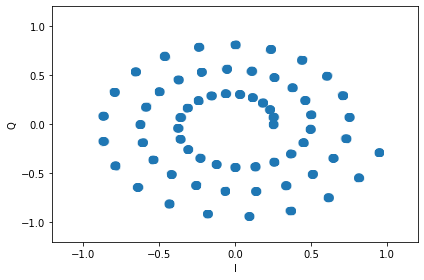

In [79]:
ask_test(m_level = 64, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

(0.506, 0.16069166666666668)

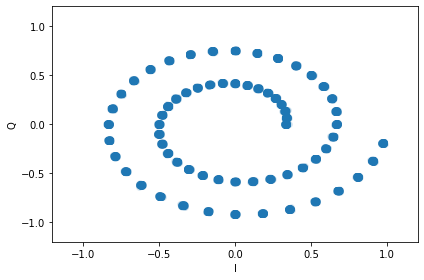

In [88]:
ask_test(m_level = 64, i_snr = 40, i_size = 20000, rotation_num = 2, plot=True)

False


(0.4679, 0.2028875)

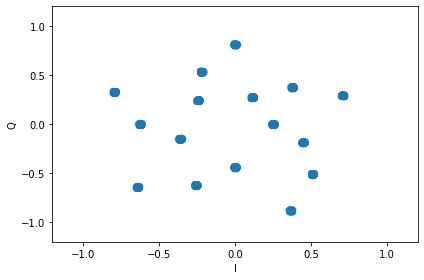

In [65]:
ask_test(m_level = 16, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

False


(0.37975, 0.251525)

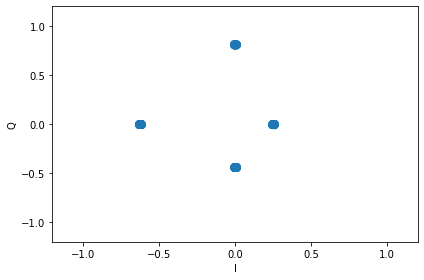

In [66]:
ask_test(m_level = 4, i_snr = 40, i_size = 20000, rotation_num = 3, plot=True)

### Archimedesの螺旋になっていることが分かると思います．

### 普通のPSKに対してSNR-BERグラフをプロットしてみましょう．

[0, 64, 0.94414, 0.42236833333333335]
[2, 64, 0.93023, 0.40208916666666666]
[4, 64, 0.913435, 0.37905666666666665]
[6, 64, 0.889655, 0.35416583333333335]
[8, 64, 0.861225, 0.32764666666666664]
[10, 64, 0.82749, 0.3020583333333333]
[12, 64, 0.78102, 0.275625]
[14, 64, 0.729, 0.2488125]
[16, 64, 0.660225, 0.22014416666666667]
[18, 64, 0.581515, 0.19176166666666666]
[20, 64, 0.48916, 0.16048833333333334]
[22, 64, 0.383445, 0.12595333333333333]
[24, 64, 0.271815, 0.08941666666666667]
[26, 64, 0.166085, 0.05428416666666667]
[28, 64, 0.081665, 0.026965]
[30, 64, 0.02815, 0.0091625]
[32, 64, 0.00548, 0.0017991666666666666]
[34, 64, 0.00048, 0.00016166666666666668]
[36, 64, 1e-05, 2.5e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.98827, 0.5518883333333333]
[2, 64, 0.984515, 0.5327183333333333]
[4, 64, 0.98164, 0.5165233333333333]
[6, 64, 0.977105, 0.50051]
[8, 64, 0.97267, 0.4828558333333333]
[10, 64, 0.96641, 0.46578583333333334]
[12, 64, 0.95996, 0.448205]
[14, 64, 0.951445, 0.4290775]
[16, 64, 0.938805

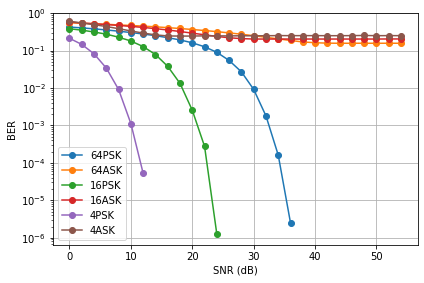

In [89]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")

    #ASK
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = ask_test(m, snr, size, rotation_num = 2)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}ASK")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_RRSK_rot2.png")
plt.savefig("PSK_RRST_rot2.pdf")

[0, 64, 0.94261, 0.42167]
[2, 64, 0.92955, 0.4016633333333333]
[4, 64, 0.912445, 0.37952583333333334]
[6, 64, 0.89024, 0.35425083333333335]
[8, 64, 0.86099, 0.32776916666666667]
[10, 64, 0.82666, 0.30265416666666667]
[12, 64, 0.781695, 0.2758525]
[14, 64, 0.72958, 0.24966333333333332]
[16, 64, 0.66342, 0.22159416666666668]
[18, 64, 0.58204, 0.19148666666666667]
[20, 64, 0.486805, 0.16003833333333334]
[22, 64, 0.381295, 0.12485916666666666]
[24, 64, 0.27015, 0.088215]
[26, 64, 0.16668, 0.054968333333333334]
[28, 64, 0.08179, 0.027090833333333335]
[30, 64, 0.02863, 0.009375]
[32, 64, 0.005785, 0.0018866666666666667]
[34, 64, 0.00055, 0.00017666666666666666]
[36, 64, 2e-05, 6.666666666666667e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.986615, 0.5441841666666667]
[2, 64, 0.983565, 0.52659]
[4, 64, 0.979665, 0.5079025]
[6, 64, 0.97494, 0.4917916666666667]
[8, 64, 0.96924, 0.47385083333333333]
[10, 64, 0.9618, 0.45410666666666666]
[12, 64, 0.95296, 0.434945]
[14, 64, 0.94339, 0.41434583333333336]
[16,

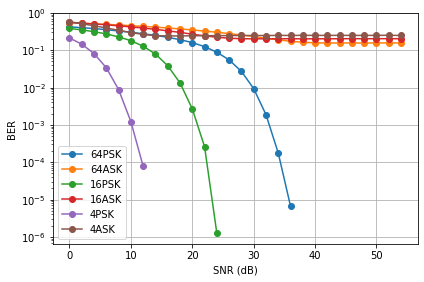

In [90]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-8:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")

    #ASK
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = ask_test(m, snr, size, rotation_num = 3)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}ASK")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_RRST_rot3.png")
plt.savefig("PSK_RRST_rot3.pdf")